In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
# Particle Parameters
v = 70  # Particle velocity
epsilon = 1e-0  # Strength of the potential
sigma = 1  # Diameter of the particles
mu = 1 #particle mass for yukawa force
particle_radius = sigma / 2  # Particle radius
r_cutoff = sigma * 2**(1/6)  # Cutoff distance for potential
D_t = 0.01  # Diffusion coefficient for translation
D_r = 0.019  # Diffusion coefficient for rotation
poisson_lambda = 0.9  # Poisson lambda for run-and-tumble
run_and_tumble = True  # True for RnT Particle, False for ABP

# Simulation Parameters
num_particles = 100  # Number of particles
num_steps = 100  # Number of steps in the simulation
T = 1  # Final Time
dt = T / num_steps  # delta t
box_size = 30  # Size of the box
boundary_condition = "periodic"  # Boundary condition: "periodic" or "none"

# Generate Wiener processes (for noise in position and angle updates)
wiener_x = np.random.standard_normal([num_steps, num_particles])
wiener_y = np.random.standard_normal([num_steps, num_particles])

# Store the initial positions and angles
positions = np.zeros([num_steps, num_particles, 2])
thetas = np.zeros([num_steps, num_particles])

positions[0, :, 0] = np.random.uniform(1e-6, box_size, size=num_particles)
positions[0, :, 1] = np.random.uniform(1e-6, box_size, size=num_particles)
thetas[0] = np.random.uniform(0, 2 * math.pi, size=num_particles)

# Initialize tracking variables for run and tumble durations
run_durations = np.zeros(num_particles)
tumble_durations = np.zeros(num_particles)
run_history = [[] for _ in range(num_particles)]  # List of lists to track run durations for each particle
tumble_history = [[] for _ in range(num_particles)]  # List of lists to track tumble durations for each particle

# Initialize the state (rho) for each particle at t=0 based on Poisson process
p = 0.5
rho_history = np.zeros([num_steps,num_particles])
rho_history[0] = np.random.choice([1, 0], size=num_particles, p=[p,1-p])

potentials = np.zeros((num_steps, num_particles))

In [ ]:
# Function to calculate WCA force
def calculate_wca_force(xi, xj, yi, yj, sigma, box_size, boundary_condition,epsilon,r_cutoff):
    dx = xi - xj
    dy = yi - yj
    if boundary_condition == "periodic":
        dx = dx - np.round(dx / box_size) * box_size
        dy = dy - np.round(dy / box_size) * box_size

    r_ij = np.sqrt(dx**2 + dy**2)
    r_ij = max(r_ij, sigma + 1e-6)  # Prevent division by zero

    if r_ij < r_cutoff:
        force_magnitude = -4 * (epsilon/r_ij) * ((12 * (sigma / r_ij)**12) - (6 * (sigma / r_ij)**6))
        fx = force_magnitude * dx / r_ij
        fy = force_magnitude * dy / r_ij
        potential = 4 * epsilon * ((sigma / r_ij)**12 - (sigma / r_ij)**6) + epsilon
        return fx, fy, potential
    return 0.0, 0.0, 0.0


# Function to calculate WCA force
def calculate_yukawa_force(xi, xj, yi, yj, mu, sigma, box_size, boundary_condition,epsilon,r_cutoff):
    dx = xi - xj
    dy = yi - yj
    if boundary_condition == "periodic":
        dx = dx - np.round(dx / box_size) * box_size
        dy = dy - np.round(dy / box_size) * box_size

    r_ij = np.sqrt(dx**2 + dy**2)
    r_ij = max(r_ij, sigma + 1e-6)  # Prevent division by zero

    if r_ij < r_cutoff:
        #force_magnitude = -mu*epsilon * np.exp(-mu*r_ij)
        fx = -epsilon*dx*np.exp(-np.sqrt(r_ij)/sigma)/(sigma * np.sqrt(r_ij))  #force_magnitude * dx / r_ij
        fy = -epsilon*dy*np.exp(-np.sqrt(r_ij)/sigma)/(sigma * np.sqrt(r_ij))  #force_magnitude * dy / r_ij
        potential = epsilon * np.exp(-r_ij/sigma)
        return fx, fy, potential
    return 0.0, 0.0, 0.0



def update_position_x(x, rho, v, theta, dt, D_t, wiener_x, box_size, boundary_condition, fx_total):
    x_new = x + (rho * v * np.cos(theta)) * dt + np.sqrt(2 * D_t * dt) * wiener_x + fx_total * dt
    if boundary_condition == "periodic":
        x_new = x_new % box_size
    elif boundary_condition == "reflective":
        if x_new > box_size:
            x_new = 2 * box_size - x_new
        elif x_new < 0:
            x_new = -x_new
    return x_new

def update_position_y(y, rho, v, theta, dt, D_t, wiener_y, box_size, boundary_condition, fy_total):
    y_new = y + (rho * v * np.sin(theta)) * dt + np.sqrt(2 * D_t * dt) * wiener_y + fy_total * dt
    if boundary_condition == "periodic":
        y_new = y_new % box_size
    elif boundary_condition == "reflective":
        if y_new > box_size:
            y_new = 2 * box_size - y_new
        elif y_new < 0:
            y_new = -y_new
    return y_new

def run_or_tumble(poisson_lambda):
    # Randomly decide if the particle runs or tumbles based on Poisson process
    rnt = np.random.choice([1, 0], p=[np.exp(-poisson_lambda), 1 - np.exp(-poisson_lambda)])
    return rnt

def run_and_tumble_duration(poisson_lambda):
    rho = run_or_tumble(poisson_lambda)
    if rho == 0:  # Tumble state
        tumble = np.random.uniform(0, 2 * math.pi)
    else:
        tumble = 0
    return rho, tumble

def update_theta(theta, poisson_lambda, dt, run_durations, tumble_durations, run_history, tumble_history, previous_rho):
    # Determine new state and angle
    rho, tumble = run_and_tumble_duration(poisson_lambda)

    if rho == 1:  # Running state
        run_durations += dt
        if previous_rho == 0:  # Just switched from tumbling to running
            tumble_history.append(tumble_durations)  # Store completed tumble duration
            tumble_durations = 0  # Reset tumble duration
    else:  # Tumble state
        tumble_durations += dt
        if previous_rho == 1:  # Just switched from running to tumbling
            run_history.append(run_durations)  # Store completed run duration
            run_durations = 0  # Reset run duration

    # Track each time step duration, adding zero for the inactive state
    run_history.append(run_durations if rho == 1 else 0)
    tumble_history.append(tumble_durations if rho == 0 else 0)

    # Update theta based on current state
    theta_new = theta + (1 - rho) * tumble
    theta_new = theta_new % (2 * math.pi)  # Ensure theta stays within [0, 2π]

    return rho, theta_new, run_durations, tumble_durations, run_history, tumble_history

In [ ]:
# Main simulation loop
for t in range(1, num_steps):
    for i in range(num_particles):
        fx_total, fy_total = 0.0, 0.0
        particle_potential = 0.0

        # Calculate WCA forces and potential with all other particles
        for j in range(num_particles):
            if i != j:
                fx, fy, potential = calculate_wca_force(
                    positions[t-1, i, 0], positions[t-1, j, 0],
                    positions[t-1, i, 1], positions[t-1, j, 1],
                    sigma, box_size, boundary_condition, epsilon, r_cutoff
                ) #xi, xj, yi, yj, sigma, box_size, boundary_condition,r_cutoff
                fx_total += fx
                fy_total += fy
                particle_potential += potential  # Accumulate potential

        # Store total potential for particle i at time t
        potentials[t, i] = particle_potential

        # Update theta (orientation) based on run/tumble dynamics
        previous_theta = thetas[t-1, i]

        # Dynamically update the state rho (run or tumble)
        rho, thetas[t, i], run_durations[i], tumble_durations[i], run_history[i], tumble_history[i] = update_theta(
            previous_theta, poisson_lambda, dt, run_durations[i], tumble_durations[i], run_history[i], tumble_history[i], rho_history[t-1,i]
        )

        # Update positions based on WCA force and other dynamics
        positions[t, i, 0] = update_position_x(
            positions[t-1, i, 0], rho, v, thetas[t-1, i], dt, D_t, wiener_x[t, i], box_size, boundary_condition, fx_total
        )
        positions[t, i, 1] = update_position_y(
            positions[t-1, i, 1], rho, v, thetas[t-1, i], dt, D_t, wiener_y[t, i], box_size, boundary_condition, fy_total
        )

# Collect run and tumble durations for all particles
all_run_durations = [duration for history in run_history for duration in history]
all_tumble_durations = [duration for history in tumble_history for duration in history]



# Reconfigure DataFrame for Plotly animation with proper size scaling
animation_data = []

for step in range(num_steps):
    frame_data = pd.DataFrame({
        'X': positions[step, :, 0],
        'Y': positions[step, :, 1],
        'Particle': np.arange(num_particles),
        'Size': [sigma] * num_particles,  # Scale size for visualization
    })
    frame_data['Time'] = step  # To enable smooth transition over time
    animation_data.append(frame_data)

df = pd.concat(animation_data).reset_index(drop=True)

size_ref = max(df['Size'])  # Adjust this formula to get particles to appear with a radius of 1 unit
# Create the animation
size_ref = sigma*5
fig = px.scatter(
    df,
    x='X', y='Y', animation_frame='Time',
    title='Enhanced Particle Simulation Animation',
    range_x=[0, box_size], range_y=[0, box_size],
    size='Size',  # Use the particle size for animation
    size_max=size_ref,  # Adjust this to fit your visualization needs
    labels={'X': 'X Position', 'Y': 'Y Position'}
)

# Add boundary shape to represent the box if periodic boundaries are selected
if boundary_condition == "periodic":
    fig.add_shape(type="rect", x0=0, y0=0, x1=box_size, y1=box_size, line=dict(color="black", width=2))

# Adding the layout settings for better visualization
fig.update_layout(
    width=700,
    height=700,
    yaxis_scaleanchor="x",
    title_text='Particle Motion with WCA Force',
    title_x=0.5,
)


fig.show()

In [ ]:
px.line(
    y = [potentials[:,i] for i in range(num_particles)]
)

In [ ]:
# Main simulation loop
for t in range(1, num_steps):
    for i in range(num_particles):
        fx_total, fy_total = 0.0, 0.0
        particle_potential = 0.0

        # Calculate WCA forces and potential with all other particles
        for j in range(num_particles):
            if i != j:
                fx, fy, potential = calculate_yukawa_force(
                    positions[t-1, i, 0], positions[t-1, j, 0],
                    positions[t-1, i, 1], positions[t-1, j, 1],
                    mu,sigma, box_size, boundary_condition, epsilon, r_cutoff
                ) #xi, xj, yi, yj, sigma, box_size, boundary_condition,r_cutoff
                fx_total += fx
                fy_total += fy
                particle_potential += potential  # Accumulate potential

        # Store total potential for particle i at time t
        potentials[t, i] = particle_potential

        # Update theta (orientation) based on run/tumble dynamics
        previous_theta = thetas[t-1, i]

        # Dynamically update the state rho (run or tumble)
        rho, thetas[t, i], run_durations[i], tumble_durations[i], run_history[i], tumble_history[i] = update_theta(
            previous_theta, poisson_lambda, dt, run_durations[i], tumble_durations[i], run_history[i], tumble_history[i], rho_history[t-1,i]
        )

        # Update positions based on WCA force and other dynamics
        positions[t, i, 0] = update_position_x(
            positions[t-1, i, 0], rho, v, thetas[t-1, i], dt, D_t, wiener_x[t, i], box_size, boundary_condition, fx_total
        )
        positions[t, i, 1] = update_position_y(
            positions[t-1, i, 1], rho, v, thetas[t-1, i], dt, D_t, wiener_y[t, i], box_size, boundary_condition, fy_total
        )

# Collect run and tumble durations for all particles
all_run_durations = [duration for history in run_history for duration in history]
all_tumble_durations = [duration for history in tumble_history for duration in history]



# Reconfigure DataFrame for Plotly animation with proper size scaling
animation_data = []

for step in range(num_steps):
    frame_data = pd.DataFrame({
        'X': positions[step, :, 0],
        'Y': positions[step, :, 1],
        'Particle': np.arange(num_particles),
        'Size': [sigma] * num_particles,  # Scale size for visualization
    })
    frame_data['Time'] = step  # To enable smooth transition over time
    animation_data.append(frame_data)

df = pd.concat(animation_data).reset_index(drop=True)

size_ref = max(df['Size'])  # Adjust this formula to get particles to appear with a radius of 1 unit
# Create the animation
size_ref = sigma*5
fig = px.scatter(
    df,
    x='X', y='Y', animation_frame='Time',
    title='Enhanced Particle Simulation Animation',
    range_x=[0, box_size], range_y=[0, box_size],
    size='Size',  # Use the particle size for animation
    size_max=size_ref,  # Adjust this to fit your visualization needs
    labels={'X': 'X Position', 'Y': 'Y Position'}
)

# Add boundary shape to represent the box if periodic boundaries are selected
if boundary_condition == "periodic":
    fig.add_shape(type="rect", x0=0, y0=0, x1=box_size, y1=box_size, line=dict(color="black", width=2))

# Adding the layout settings for better visualization
fig.update_layout(
    width=700,
    height=700,
    yaxis_scaleanchor="x",
    title_text='Particle Motion with Yukawa Force',
    title_x=0.5,
)


fig.show()

In [ ]:
px.line(
    y = [potentials[:,i] for i in range(num_particles)]
)

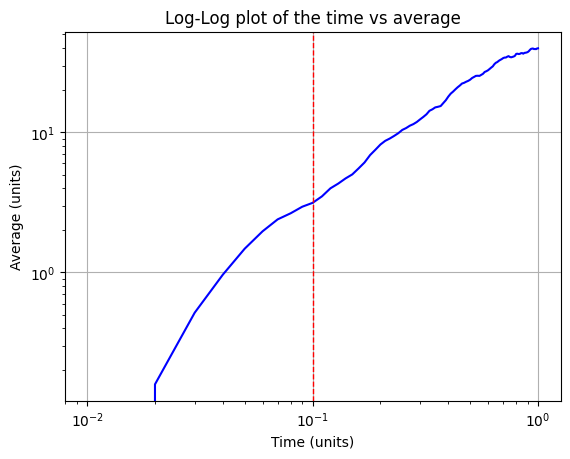

In [ ]:
a,b,c = positions.shape
lis = []
lis2 = []
for i in range(b):
    # Create a DataFrame with X and Y positions for each time step (i-th time step)
    positionsDf = pd.DataFrame(data=positions[:, i, :], columns=['X', 'Y'])

    # Calculate the squared differences in the X direction
    xDiff = positionsDf['X'] - positionsDf.at[0, 'X']
    xDiffWrapped = box_size - np.abs(xDiff)  # Calculate the wrapped distance
    positionsDf['xDiffSquared'] = np.minimum(xDiff**2, xDiffWrapped**2)  # Take the minimum of direct and wrapped squared distances

    # Calculate the squared differences in the Y direction
    yDiff = positionsDf['Y'] - positionsDf.at[0, 'Y']
    yDiffWrapped = box_size - np.abs(yDiff)  # Calculate the wrapped distance
    positionsDf['yDiffSquared'] = np.minimum(yDiff**2, yDiffWrapped**2)  # Take the minimum of direct and wrapped squared distances

    # Sum the squared differences
    positionsDf['XYSum'] = positionsDf['xDiffSquared'] + positionsDf['yDiffSquared']
    positionsDf["dt"] = dt
    positionsDf["time"] = positionsDf['dt'].cumsum()
    positionsDf["Particle"] = i

    # Append the result for the current time step
    lis.append(positionsDf['XYSum'])
    lis2.append(positionsDf)

data = pd.concat(lis,axis=1)
average = pd.DataFrame(data = data.mean(axis=1), columns = ['average'])
average['dt'] = dt
average['time'] = average['dt'].cumsum()

plt.loglog(average['time'],average['average'], linestyle='-', color='b')
plt.axvline(x=(1 / 10), color='red', linestyle='--', linewidth=1)
plt.title('Log-Log plot of the time vs average')
plt.xlabel('Time (units)')
plt.ylabel('Average (units)')
plt.grid(True)
plt.show();

In [ ]:
a, b = thetas.shape
data_list = []
for i in range(b):
  data = pd.DataFrame(data=thetas[:,i],columns=["Theta"])
  data["Particle"] = i
  data["Theta_0"] = data.at[0, 'Theta']
  data["dot"] = np.dot(data["Theta"],data["Theta_0"])
  data["Corr"] = np.cos(data["Theta"]) - np.cos(data["Theta_0"])
  data["dt"] = dt
  data["time"] = data["dt"].cumsum()
  data_list.append(data)
corr_data = pd.concat(data_list,axis = 0).reset_index(drop=True)
corr_data["Corr"] = (corr_data["Theta_0"] * corr_data["Theta"])
corr_data = corr_data.groupby("time").mean().reset_index()

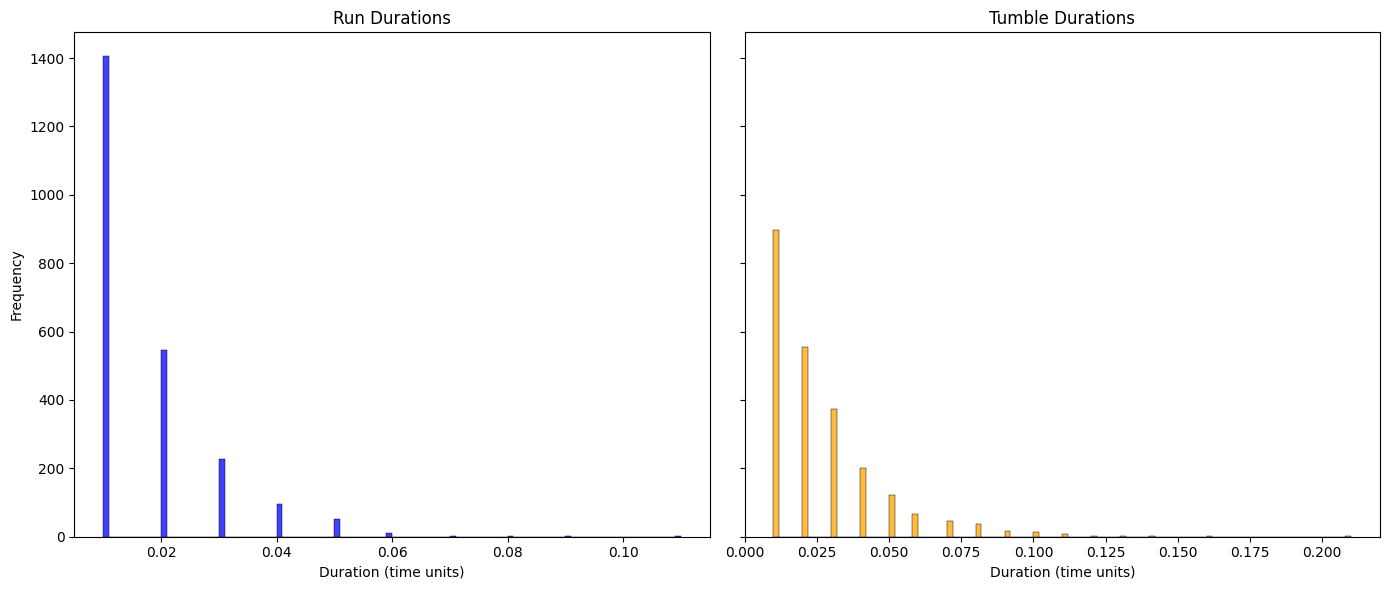

In [ ]:
run_and_tumble_durations = pd.concat(data_list,axis = 0).reset_index(drop=True)
run_and_tumble_durations["shift_1"] = run_and_tumble_durations["Theta"].shift(1)
run_and_tumble_durations["rnt_indicator"] = np.where(run_and_tumble_durations["Theta"] == run_and_tumble_durations["shift_1"], 1, 0)

# Add a column to detect changes in the 'rnt_indicator' to identify consecutive sequences
run_and_tumble_durations['change'] = run_and_tumble_durations['rnt_indicator'].ne(run_and_tumble_durations['rnt_indicator'].shift()).cumsum()

# Group by these sequence indicators and calculate the duration of each sequence
sequence_durations = run_and_tumble_durations.groupby(['rnt_indicator', 'change']).size().reset_index(name='sequence_length')

# Define the time step (dt) for duration calculation
dt = 0.01  # adjust if your actual dt is different
sequence_durations['duration'] = sequence_durations['sequence_length'] * dt

# Add a new column to label each sequence as 'run' or 'tumble'
sequence_durations['type'] = sequence_durations['rnt_indicator'].map({1: 'run', 0: 'tumble'})

# Separate the run and tumble durations
run_durations = sequence_durations[sequence_durations['type'] == 'run']['duration']
tumble_durations = sequence_durations[sequence_durations['type'] == 'tumble']['duration']

# Plotting histograms for run and tumble durations

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Histogram for Run Durations
sns.histplot(run_durations, bins=100, kde=False, ax=axes[0], color='blue')
axes[0].set_title("Run Durations")
axes[0].set_xlabel("Duration (time units)")
axes[0].set_ylabel("Frequency")

# Histogram for Tumble Durations
sns.histplot(tumble_durations, bins=100, kde=False, ax=axes[1], color='orange')
axes[1].set_title("Tumble Durations")
axes[1].set_xlabel("Duration (time units)")

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
distribution_of_orientations = run_and_tumble_durations.copy()
distribution_of_orientations["rounded_theta"] = np.round(distribution_of_orientations["Theta"],2)
distribution_of_orientations = distribution_of_orientations["rounded_theta"].value_counts().reset_index()

distribution_of_orientations["prob"] = distribution_of_orientations["count"]/len(distribution_of_orientations)
distribution_of_orientations = distribution_of_orientations.sort_values("rounded_theta").reset_index(drop=True)
distribution_of_orientations["cumsum"] = distribution_of_orientations["rounded_theta"].cumsum()

px.line(
    distribution_of_orientations,
    x = "rounded_theta",
    y = "prob"
)

In [ ]:
px.line(
    y = [np.exp(-(i/1000)/D_t) for i in range(num_steps)]
)

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Initialize an empty list for the frames of data
animation_data = []

# Populate each frame's data
for step in range(num_steps):
    frame_data = pd.DataFrame({
        'X': positions[step, :, 0],
        'Y': positions[step, :, 1],
        'Particle': np.arange(num_particles),
        'Size': [sigma] * num_particles,  # Particle size
        'InteractionRange': [r_cutoff] * num_particles  # Shaded region size for interaction range
    })
    frame_data['Time'] = step  # Time step for animation frames
    animation_data.append(frame_data)

# Concatenate all frames into a single DataFrame
df = pd.concat(animation_data).reset_index(drop=True)

# Set up the figure and create the initial frame
fig = go.Figure(
    data=[
        go.Scatter(
            x=df[df['Time'] == 0]['X'],
            y=df[df['Time'] == 0]['Y'],
            mode='markers',
            marker=dict(
                size=df[df['Time'] == 0]['Size'] * 5,  # Scale particle size
                color='blue',
                opacity=1.0,
                sizemode='diameter'
            ),
            name='Particles'
        ),
        go.Scatter(
            x=df[df['Time'] == 0]['X'],
            y=df[df['Time'] == 0]['Y'],
            mode='markers',
            marker=dict(
                size=df[df['Time'] == 0]['InteractionRange'] * 5,  # Scale interaction range
                color='rgba(50, 110, 60, 0.2)',  # Light color with transparency
                sizemode='diameter',
            ),
            name='Interaction Range'
        )
    ],
    layout=go.Layout(
        title='Enhanced Particle Simulation Animation with Interaction Range',
        xaxis=dict(range=[0, box_size], title='X Position'),
        yaxis=dict(range=[0, box_size], title='Y Position', scaleanchor="x"),
        width=700,
        height=700,
    )
)

# Create frames for each time step
frames = []
for step in range(num_steps):
    frame = go.Frame(
        data=[
            go.Scatter(
                x=df[df['Time'] == step]['X'],
                y=df[df['Time'] == step]['Y'],
                mode='markers',
                marker=dict(
                    size=df[df['Time'] == step]['Size'] * 5,  # Particle size scaling
                    color='blue',
                    opacity=1.0,
                    sizemode='diameter'
                ),
                name='Particles'
            ),
            go.Scatter(
                x=df[df['Time'] == step]['X'],
                y=df[df['Time'] == step]['Y'],
                mode='markers',
                marker=dict(
                    size=df[df['Time'] == step]['InteractionRange'] * 5,  # Interaction range scaling
                    color='rgba(50, 110, 60, 0.2)',  # Light color with transparency
                    sizemode='diameter',
                ),
                name='Interaction Range'
            )
        ],
        name=str(step)
    )
    frames.append(frame)

# Add all frames to the figure
fig.frames = frames

# Add slider for frame control
sliders = [{
    'steps': [
        {
            'method': 'animate',
            'label': str(step),
            'args': [[str(step)], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate'}]
        }
        for step in range(num_steps)
    ],
    'transition': {'duration': 0},
    'x': 0.1,
    'len': 0.9,
    'currentvalue': {'font': {'size': 20}, 'prefix': 'Frame: ', 'visible': True, 'xanchor': 'center'}
}]

# Add play/pause buttons and slider to layout
fig.update_layout(
    updatemenus=[{
        'type': 'buttons',
        'showactive': False,
        'buttons': [{
            'label': 'Play',
            'method': 'animate',
            'args': [None, {'frame': {'duration': 100, 'redraw': True}, 'fromcurrent': True, 'mode': 'immediate'}]
        }, {
            'label': 'Pause',
            'method': 'animate',
            'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate'}]
        }]
    }],
    sliders=sliders
)

# Add boundary box if periodic boundary conditions are specified
if boundary_condition == "periodic":
    fig.add_shape(
        type="rect", x0=0, y0=0, x1=box_size, y1=box_size,
        line=dict(color="black", width=2)
    )

# Show the animation with the slider
fig.show()

In [ ]:
# single_trajectory = xy_positions.copy()
# single_trajectory = single_trajectory[single_trajectory["Particle"] == 0]
# fig = go.Figure(data=[go.Scatter3d(
#     x=single_trajectory["X"], y=single_trajectory["Y"], z=single_trajectory["time"],
#     mode='lines',
#     line=dict(width=3, color='black')
# )])

# # Set plot title and labels
# fig.update_layout(
#     title='3D Line Plot',
#     scene=dict(
#         xaxis_title='Movement X',
#         yaxis_title='Movement Y',
#         zaxis_title='Time'
#     )
# )

# fig.show()